In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install --upgrade --force-reinstall --no-deps transformers
!pip install --upgrade --force-reinstall --no-deps datasets

!pip install --upgrade --force-reinstall --no-deps huggingface_hub

!pip install --upgrade --force-reinstall --no-deps pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.27.3-py3-none-any.whl (6.8 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.27.3
    Uninstalling transformers-4.27.3:
      Successfully uninstalled transformers-4.27.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached datasets-2.10.1-py3-none-any.whl (469 kB)
  Attempting uninstall: datasets
    Found existing installation: datasets 2.10.1
    Uninstalling datasets-2.10.1:
      Successfully uninstalled datasets-2.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached huggingface_hub-0.13.3-py3-none-any.whl (199 kB)
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.13.3
    Uninstalling huggingface-hub-0.13.3:
      Successfully uninstalled huggingface

In [3]:
from datasets import load_dataset,DatasetDict
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoTokenizer,TFBertModel
from transformers import TextClassificationPipeline

Read Data

In [4]:
pandas_df =pd.read_csv("/content/HateSpeechData.csv")
pandas_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


See instances per class

In [5]:
pandas_df.value_counts(subset='class')

class
1    19190
2     4163
0     1430
dtype: int64

Text(0, 0.5, 'Number of Occurances')

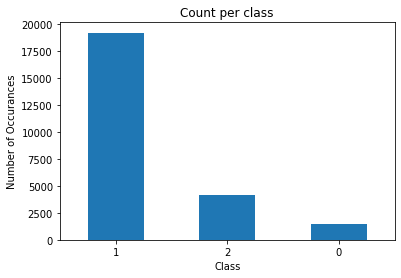

In [6]:
count_classes = pandas_df.value_counts(pandas_df['class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Count per class")
plt.xlabel("Class")
plt.ylabel("Number of Occurances")

Clean tweets

In [7]:
pandas_df['tweet_cleaned'] = pandas_df['tweet'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)
pandas_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,tweet_cleaned
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,!!! RT : As a woman you shouldn't complain abo...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitch...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,!!!!!!!!! RT _G_Anderson: _based she look like...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,!!!!!!!!!!!!! RT : The shit you hear about me ...


In [8]:
data_tweet_cleaned = pandas_df['tweet_cleaned'].to_list()

data_class = pandas_df['class'].to_list()

Split dataset

In [9]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(data_tweet_cleaned, data_class, test_size = 0.2, random_state = 0 )
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.02, random_state = 0 )

Tokenizing

In [10]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
max_length = 512
train_encodings = tokenizer(train_texts,truncation = True, padding = True,max_length=max_length )
val_encodings = tokenizer(val_texts,truncation = True, padding = True ,max_length=max_length )

Make new dataset with embeddings and labels

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

In [12]:
!pip install tensorflow-addons==0.16.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from transformers.models.bert.modeling_tf_bert import TFBertForSequenceClassification
trainer_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 3 )

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load BERT model

In [14]:
from transformers import TFBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',          
    num_train_epochs=2,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=1e-5,               
    logging_dir='./logs',            
    eval_steps=100                   
)

with training_args.strategy.scope():
    trainer_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 3 )


trainer = TFTrainer(
    model=trainer_model,                 
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,        
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.9/dist-packages/transformers/trainer_tf.py:118: FutureWarning: The class `TFTrainer` is deprecated and will be removed in version 5 of Transformers. We recommend using native Keras instead, by calling methods like `fit()` and `predict()` directly on the model object. Detailed examples of the Keras style can be found in our examples at https://github.com/huggingface/transformers/tree/main/examples/tensorflow
  warnings.warn(


Train 

In [15]:
trainer.train()

Predict

In [16]:
predictions = trainer.predict(val_dataset)
print(predictions.predictions.shape, predictions.label_ids.shape)

(4957, 3) (4957,)


In [17]:
import numpy as np

preds = np.argmax(predictions.predictions, axis = -1)



In [18]:
preds

array([1, 1, 1, ..., 1, 1, 1])

In [19]:
pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 6.4 MB/s eta 0:00:00


Evaluation metrics

In [20]:
import evaluate

metric = evaluate.load("f1")
metric.compute(predictions=preds, references=predictions.label_ids,  average ='weighted')

{'f1': 0.9093395399347749}

In [21]:
metric = evaluate.load("accuracy")
metric.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.9142626588662498}